In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path (update with your actual path)
dataset_path = "/content/drive/MyDrive/Stenosis detection/arcade"
os.listdir(dataset_path)  # List dataset files


Mounted at /content/drive


['stenosis',
 'syntax',
 'dataset.yaml',
 'weights',
 'weights_CBAM+optimization+noaug',
 'dataset2.yaml',
 'train_masks',
 'val_masks',
 'train_images',
 'val_images',
 'weights_yolov9+CBAM+SimCLR']

In [ ]:
dataset_path = "/content/drive/MyDrive/Stenosis detection/arcade"


In [ ]:
os.listdir(dataset_path)  # List dataset files


['stenosis', 'syntax', 'dataset.yaml', 'weights']

In [ ]:
import json
import os

def coco_to_yolo(json_file, output_path, images_path):
    with open(json_file) as f:
        data = json.load(f)

    images = {img["id"]: img["file_name"] for img in data["images"]}
    annotations = data["annotations"]

    os.makedirs(output_path, exist_ok=True)

    for ann in annotations:
        img_id = ann["image_id"]
        bbox = ann["bbox"]  # [x, y, width, height]

        img_name = images[img_id]
        txt_name = os.path.splitext(img_name)[0] + ".txt"

        x, y, w, h = bbox
        x_center, y_center = x + w/2, y + h/2

        # Normalize
        img_width, img_height = 512, 512  # Assuming all images are 512x512
        x_center /= img_width
        y_center /= img_height
        w /= img_width
        h /= img_height

        # Write to file
        with open(os.path.join(output_path, txt_name), "a") as f:
            f.write(f"0 {x_center} {y_center} {w} {h}\n")

# Convert annotations


In [ ]:
coco_to_yolo(
    json_file=f"{dataset_path}/stenosis/train/annotations/train.json",
    output_path=f"{dataset_path}/stenosis/train/labels",
    images_path=f"{dataset_path}/stenosis/train/images"
)
coco_to_yolo(
    json_file=f"{dataset_path}/stenosis/val/annotations/val.json",
    output_path=f"{dataset_path}/stenosis/val/labels",
    images_path=f"{dataset_path}/stenosis/val/images"
)
coco_to_yolo(
    json_file=f"{dataset_path}/stenosis/test/annotations/test.json",
    output_path=f"{dataset_path}/stenosis/test/labels",
    images_path=f"{dataset_path}/stenosis/test/images"
)

In [ ]:
coco_to_yolo(
    json_file=f"{dataset_path}/stenosis/train/annotations/train.json",
    output_path=f"{dataset_path}/stenosis/train/augmented_train/augmented_images",
    images_path=f"{dataset_path}/stenosis/train/augmented_train/labels"
)


In [ ]:

coco_to_yolo(
    json_file=f"{dataset_path}/stenosis/val/annotations/val.json",
    output_path=f"{dataset_path}/stenosis/val/augmented_labels",
    images_path=f"{dataset_path}/stenosis/val/augmented_image"
)


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
import cv2
import torch
import os
from ultralytics import YOLO

# Load trained YOLO model
model = YOLO("runs/detect/train/weights/best.pt")

# Path to test images directory
test_images_dir = f"{dataset_path}/stenosis/train/images"
output_dir = f"{dataset_path}/stenosis/new_train_images"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get list of all images in test dataset
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Process each image
for img_name in image_files:
    img_path = os.path.join(test_images_dir, img_name)
    img = cv2.imread(img_path)

    # Run YOLO prediction
    results = model(img)

    # Draw bounding boxes
    for box in results[0].boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Save the image with detections
    output_path = os.path.join(output_dir, f"detected_{img_name}")
    cv2.imwrite(output_path, img)

print(f"Batch processing complete! Results saved in: {output_dir}")


Improving the model via optimization

In [ ]:
from torch import nn
model = YOLO("yolov8s.pt")
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, 7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x * self.channel_attention(x)
        return x * self.spatial_attention(torch.cat([
            torch.mean(x, dim=1, keepdim=True),
            torch.max(x, dim=1, keepdim=True)[0]
        ], dim=1))

model.model.neck = CBAM(channels=256)  # Apply CBAM to the neck



YOLOV9 model with CBAM neck and SimCLR backbone

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import glob

# Define Transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor()
])

class StenosisDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(root_dir + "/*.jpg") + glob.glob(root_dir + "/*.png")  # Adjust for your formats
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels

        if self.transform:
            image = self.transform(image)

        return image, 0  # Dummy label (not needed for SSL)

# Set Dataset Path
dataset_path = "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/train/images"
dataset = StenosisDataset(dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Check if images are loading correctly
for images, _ in dataloader:
    print("Batch Loaded:", images.shape)
    break  # Check one batch


Batch Loaded: torch.Size([8, 3, 224, 224])


In [ ]:
dataset_path = "/content/drive/MyDrive/Stenosis detection/arcade"


In [ ]:
# Load Pretrained ResNet50 (Feature Extractor)
from torchvision.models import resnet50
import torch.nn as nn

backbone = resnet50(pretrained=True)
backbone.fc = nn.Identity()  # Remove final classification layer

# Define Projection Head
projection_head = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 128)
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

class SimCLR(nn.Module):
    def __init__(self, backbone, projection_head):
        super(SimCLR, self).__init__()
        self.backbone = backbone
        self.projection_head = projection_head

    def forward(self, x):
        features = self.backbone(x)
        return self.projection_head(features)

In [ ]:
import torch.optim as optim

model = SimCLR(backbone, projection_head).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(10):  # Train for 10 epochs
    for images, _ in dataloader:
        images = images.cuda()
        features = model(images)
        loss = -torch.mean(features)  # Dummy contrastive loss (replace with real loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
torch.save(model.backbone.state_dict(), "simclr_backbone.pth")


In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov9c.pt")

# Replace YOLOv8 backbone with SimCLR pre-trained backbone
model.model.backbone = backbone  # Use the SimCLR-trained model


100%|██████████| 21.5M/21.5M [00:00<00:00, 378MB/s]


In [ ]:
from torch import nn
import torch

# CBAM Attention Module
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()

        # Channel Attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Avg Pooling
            nn.Conv2d(channels, channels // reduction, 1),  # Downscale
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1),  # Upscale
            nn.Sigmoid()  # Attention weights
        )

        # Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, 7, padding=3),  # Convolve across spatial dims
            nn.Sigmoid()
        )

    def forward(self, x):
        # Apply Channel Attention
        x = x * self.channel_attention(x)

        # Apply Spatial Attention
        spatial_map = torch.cat([
            torch.mean(x, dim=1, keepdim=True),  # Mean pooling
            torch.max(x, dim=1, keepdim=True)[0]  # Max pooling
        ], dim=1)

        return x * self.spatial_attention(spatial_map)


In [ ]:
from ultralytics import YOLO

# Load YOLOv8
model = YOLO("yolov9c.pt")

# Load Pretrained SimCLR as Backbone
backbone = resnet50(pretrained=False)
backbone.fc = nn.Identity()  # Remove classification head
backbone.load_state_dict(torch.load("simclr_backbone.pth"))  # Load pretrained weights

# Replace YOLOv8 Backbone with SimCLR
model.model.backbone = backbone

# Replace YOLOv8 Neck with CBAM
model.model.neck = CBAM(channels=256)

# Save the updated model
model.save("yolov8_simclr_cbam.pt")


100%|██████████| 14.7M/14.7M [00:00<00:00, 104MB/s] 


Self supervised learning + CBAM

In [ ]:
model.train(
    data=f"{dataset_path}/dataset.yaml",
    epochs=100,
    imgsz=[512, 640, 768],
    batch=16,
    mosaic=1.0,  # Enable Mosaic augmentation
    mixup=0.5,  # Enable MixUp
    device="cuda",
    optimizer="AdamW",  # Adaptive optimizer improves small object detection
    lr0=0.01,  # Lower learning rate for better fine-tuning
    iou=0.3,  # Lower IoU threshold to detect small stenotic areas
    fliplr=0.5,  # 50% flip augmentation
    perspective=0.5,
    hsv_h=0.015,  # HSV color augmentation
    hsv_s=0.7,  # Color saturation
    hsv_v=0.4,  # Brightness adjustments
    label_smoothing=0.1
)
model.save("yolov9_simclr_cbam1.pt")

Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/content/drive/MyDrive/Stenosis detection/arcade/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.3, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

AMP: checks passed ✅


/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:919: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Stenosis detection/arcade/stenosis/val/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      1/100       3.5G      1.938      2.411      1.678         26        512: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.364       0.34      0.258     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      2/100      3.48G      1.956      2.429      1.684         12        512: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.325      0.397      0.263     0.0853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      3/100      3.46G      1.966      2.429       1.69         26        512: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.296      0.325      0.213     0.0712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      4/100      3.48G      2.006      2.462        1.7         14        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.291       0.34      0.216      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      5/100      3.48G      2.026      2.461      1.726         10        512: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.285      0.387      0.242     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      6/100      3.46G      1.992      2.438      1.704         16        512: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.371      0.392      0.301     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      7/100      3.47G      1.952      2.409       1.68         15        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.343        0.3      0.234      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      8/100      3.46G       1.98       2.43      1.702         19        512: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.308      0.369      0.244     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      9/100      3.48G       1.94       2.37      1.667         17        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.335      0.342      0.252     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     10/100      3.46G      1.937      2.345      1.665         18        512: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.375      0.392      0.304      0.093

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     11/100      3.47G      1.924      2.382      1.674         23        512: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406       0.36      0.342      0.276      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     12/100      3.48G      1.938      2.399      1.676         18        512: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.329      0.379      0.236     0.0764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     13/100      3.48G      1.912      2.336      1.671         20        512: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.356      0.392      0.295     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     14/100      3.46G      1.888      2.326      1.648         11        512: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.353      0.352      0.273     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     15/100      3.47G      1.908      2.285      1.647         19        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.326      0.362      0.264     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     16/100      3.46G      1.907      2.339      1.633         13        512: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.333      0.379      0.269      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     17/100      3.47G      1.902      2.311      1.645         25        512: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.335      0.374      0.281     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     18/100      3.46G      1.848      2.258      1.612         17        512: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.322      0.369      0.243       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     19/100      3.47G      1.861      2.273      1.623         12        512: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.341      0.377      0.258     0.0794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     20/100      3.46G      1.869      2.286      1.627         15        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406        0.3      0.367      0.232     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     21/100      3.47G      1.868      2.274      1.619         36        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.344      0.362      0.268     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     22/100      3.46G      1.858      2.266      1.617         23        512: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.345      0.392      0.276     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     23/100      3.47G      1.816      2.209      1.593         12        512: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406       0.36      0.392      0.283      0.086

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     24/100      3.48G      1.847      2.204      1.604         16        512: 100%|██████████| 63/63 [00:35<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.344      0.397      0.267     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     25/100      3.48G      1.851      2.257      1.617         20        512: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.346      0.384      0.295      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     26/100      3.46G      1.795      2.224      1.603          9        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.332      0.404      0.268     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     27/100      3.47G       1.82      2.232      1.603         18        512: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.351      0.389      0.285     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     28/100      3.48G      1.782       2.14      1.567         12        512: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.381      0.394      0.298      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     29/100      3.48G      1.803      2.195      1.573         21        512: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.439      0.369      0.311      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     30/100      3.46G      1.816      2.216      1.574          8        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.338      0.392      0.305     0.0975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     31/100      3.47G      1.784      2.145      1.561         18        512: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.335      0.419      0.282     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     32/100      3.47G      1.759      2.105      1.567         29        512: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.405      0.397      0.316       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     33/100      3.48G      1.773      2.107       1.57         15        512: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.366      0.431       0.29     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     34/100      3.46G      1.785      2.122      1.561         17        512: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.383      0.362      0.306      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     35/100      3.47G      1.785      2.136      1.586          7        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.373      0.394      0.306      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     36/100      3.46G      1.785       2.11      1.579         14        512: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.375      0.416      0.326      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     37/100      3.48G      1.769        2.1      1.556         16        512: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.327      0.429      0.298      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     38/100      3.45G      1.743      2.047      1.546         17        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406       0.37      0.401       0.32      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     39/100      3.47G      1.752      2.076      1.556         16        512: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.375      0.357      0.309      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     40/100      3.46G      1.745      2.084      1.541         15        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.359      0.426      0.316      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     41/100      3.46G      1.748      2.069      1.542          9        512: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.366       0.42      0.311      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     42/100      3.46G       1.74      2.098      1.554         24        512: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.398       0.35       0.31      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     43/100      3.47G      1.765      2.068      1.565         22        512: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.375      0.433      0.331      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     44/100      3.48G      1.755      2.083      1.572         16        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406        0.4      0.352       0.31        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     45/100      3.48G      1.745      2.038      1.544         17        512: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.436      0.342       0.31      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     46/100      3.46G       1.71      2.037      1.533         21        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.371      0.429       0.31      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     47/100      3.47G      1.752      2.084      1.558         21        512: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.379      0.433      0.329      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     48/100      3.46G      1.708      1.971      1.517         11        512: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.389      0.416      0.335      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     49/100      3.48G      1.715      2.029      1.542         19        512: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.389      0.379      0.312      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     50/100      3.46G      1.713      2.015      1.521         26        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.367      0.379      0.306     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     51/100      3.47G      1.705      2.016      1.518          8        512: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.369      0.433      0.316     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     52/100      3.47G      1.663      1.967      1.492         10        512: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.403      0.409      0.339      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     53/100       3.5G      1.677      1.994      1.517         18        512: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.454      0.385      0.345      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     54/100      3.44G      1.691      1.957      1.499         12        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.382      0.429      0.301        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     55/100      3.46G      1.647      1.927      1.496         27        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.408      0.397       0.34      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     56/100      3.46G      1.673      1.933      1.492         13        512: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406        0.4      0.414      0.315      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     57/100      3.47G      1.675      1.992      1.504         16        512: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.398      0.419      0.333      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     58/100      3.46G      1.637       1.89      1.475         12        512: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.396      0.429      0.345      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     59/100      3.46G       1.65      1.912       1.48         33        512: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.394      0.379      0.304      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     60/100      3.47G      1.644      1.863       1.47         10        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.419      0.416      0.326      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     61/100      3.48G      1.654      1.901      1.481         18        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.424      0.369      0.321      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     62/100      3.46G      1.624      1.866      1.467         18        512: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.413      0.358      0.314      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     63/100      3.51G      1.641      1.863      1.474         15        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.397      0.412      0.307      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     64/100      3.46G       1.64      1.867      1.469         12        512: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406       0.38      0.389      0.307      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     65/100      3.47G        1.6      1.844      1.445         14        512: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.413      0.403      0.348      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     66/100      3.49G      1.634      1.836      1.472         21        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.402      0.419      0.328      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     67/100      3.47G      1.617       1.85      1.456         15        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.427      0.345      0.306      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     68/100      3.48G       1.62      1.832      1.457         13        512: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.388      0.377      0.302      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     69/100      3.47G      1.609      1.781      1.444         15        512: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.366      0.438       0.33      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     70/100      3.45G       1.59      1.789      1.442         18        512: 100%|██████████| 63/63 [00:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.397      0.394      0.331      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     71/100      3.47G      1.583      1.746       1.43         10        512: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.429      0.404      0.326      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     72/100      3.46G      1.564       1.78      1.413         12        512: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.348      0.421      0.313      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     73/100      3.48G      1.555       1.75      1.431         16        512: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.425      0.406      0.343      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     74/100      3.46G      1.571      1.764      1.419         22        512: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.424      0.387       0.34       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     75/100      3.47G      1.571      1.724      1.422         16        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.501      0.352      0.316      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     76/100      3.48G      1.559       1.75      1.424         16        512: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.412      0.394      0.318      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     77/100      3.48G      1.545      1.725       1.42         14        512: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.396      0.393      0.329      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     78/100      3.46G      1.567      1.734      1.419         21        512: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.421      0.426      0.353      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     79/100      3.47G      1.549      1.749      1.424         14        512: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.407      0.395      0.322      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     80/100      3.48G      1.529      1.677      1.402          9        512: 100%|██████████| 63/63 [00:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.469       0.36       0.33      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     81/100      3.47G      1.574      1.705      1.424         31        512: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406       0.42      0.387      0.342      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     82/100      3.46G      1.537      1.706      1.412         13        512: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.367      0.453      0.319      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     83/100      3.47G      1.522      1.675      1.385         20        512: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406        0.4      0.438      0.329      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     84/100      3.46G      1.532      1.688      1.403         18        512: 100%|██████████| 63/63 [00:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406       0.39      0.399       0.32      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     85/100      3.47G       1.53      1.697       1.41         33        512: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.385      0.421      0.332      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     86/100      3.45G      1.497      1.661      1.386         22        512: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.412      0.387      0.323      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     87/100      3.51G      1.493      1.627       1.37         26        512: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.423      0.384      0.323      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     88/100      3.46G      1.514      1.661      1.395         19        512: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.385      0.394      0.302      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     89/100      3.49G      1.501      1.656      1.392         18        512: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.434      0.368       0.32      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     90/100      3.46G      1.505      1.638      1.388         11        512: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.448      0.369      0.318      0.115


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     91/100      3.47G      1.245      1.369      1.284          9        512: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.389      0.384      0.302      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     92/100      3.46G      1.222      1.261      1.264          7        512: 100%|██████████| 63/63 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.405      0.382      0.318      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     93/100      3.46G      1.195      1.238      1.268          6        512: 100%|██████████| 63/63 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.439      0.342      0.315      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     94/100      3.44G      1.187      1.208      1.255          7        512: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.377      0.419      0.314       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     95/100      3.47G       1.16      1.144      1.231          9        512: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.377      0.438      0.321      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     96/100      3.46G      1.168      1.163      1.237          6        512: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.401      0.394      0.309       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     97/100      3.46G      1.165      1.179      1.248          5        512: 100%|██████████| 63/63 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.438      0.377      0.314      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     98/100      3.44G      1.144      1.122      1.231          8        512: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.425      0.389       0.32       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
     99/100      3.47G      1.156      1.143      1.235          6        512: 100%|██████████| 63/63 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.393      0.406      0.324      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
    100/100      3.46G      1.146      1.134      1.225         13        512: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      

                   all        200        406      0.415      0.399      0.327      0.113



100 epochs completed in 1.062 hours.
Optimizer stripped from runs/detect/train22/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train22/weights/best.pt, 15.2MB

Validating runs/detect/train22/weights/best.pt...
Ultralytics 8.3.79 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


                   all        200        406      0.421      0.426      0.354      0.127
Speed: 0.4ms preprocess, 6.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train22


In [ ]:
from ultralytics import YOLO

# Load trained YOLOv9 model with best weights
yolo_model = YOLO("/content/drive/MyDrive/Stenosis detection/arcade/weights_yolov9+CBAM+SimCLR/best.pt")


Creating segmentation masks

In [ ]:
image_path= "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png"
def yolo_detect(image_path):
   results = yolo_model(image_path)  # Run inference
   # Extract bounding boxes from YOLO's output
   detected_boxes = []
   for result in results:
    for box in result.boxes.data:
      xmin, ymin, xmax, ymax, confidence, class_id = box.cpu().numpy()
      detected_boxes.append([xmin, ymin, xmax, ymax, confidence, int(class_id)])
   return {image_path: detected_boxes} # List of detected boxes



In [ ]:
import torchvision
from torchvision import transforms
from PIL import Image

# Load Faster R-CNN
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()

def refine_with_faster_rcnn(image_path, yolo_results):
    """
    Uses Faster R-CNN to refine stenosis detection.
    """
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    # Extract YOLO bounding boxes
    boxes = yolo_results.pandas().xyxy[0][['xmin', 'ymin', 'xmax', 'ymax']].values

    refined_detections = []
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)

        # Crop ROI
        roi = image.crop((x_min, y_min, x_max, y_max))

        # Run Faster R-CNN
        with torch.no_grad():
            pred = faster_rcnn(transform(roi).unsqueeze(0))

        refined_detections.append(pred)

    return refined_detections


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 116MB/s]


Creating ground truth labels for comparison

In [ ]:
import json
import numpy as np

def load_ground_truth(json_path):
    """
    Loads ground truth bounding boxes from the dataset JSON file.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    ground_truth = {}

    for image in data['images']:
        img_id = image['id']
        img_filename = image['file_name']

        # Get bounding boxes for this image
        bboxes = []
        for ann in data['annotations']:
            if ann['image_id'] == img_id:
                bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
                xmin, ymin, w, h = bbox
                xmax, ymax = xmin + w, ymin + h
                bboxes.append([xmin, ymin, xmax, ymax, 1])  # Class "stenosis" = 1

        ground_truth[img_filename] = np.array(bboxes)  # Store as numpy array

    return ground_truth


In [ ]:
json_file=f"{dataset_path}/stenosis/test/annotations/test.json"

In [ ]:
gt= load_ground_truth(json_file)

In [ ]:
image_path= "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png"


In [ ]:
# Step 1: Load Ground Truth
ground_truth = gt

# Step 2: Run YOLOv9 for initial detection
yolo_results = yolo_detect(image_path)




image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png: 512x512 1 stenosis, 658.0ms
Speed: 9.0ms preprocess, 658.0ms inference, 36.0ms postprocess per image at shape (1, 3, 512, 512)


In [ ]:
print(yolo_results)

{'/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png': [[233.7604, 232.2281, 275.3721, 295.8299, 0.37030405, 0]]}


In [ ]:
import numpy as np

def compute_iou(pred_box, gt_box):
    """
    Compute IoU (Intersection over Union) between a predicted bbox and ground truth bbox.
    """
    xA = max(pred_box[0], gt_box[0])  # Intersection xmin
    yA = max(pred_box[1], gt_box[1])  # Intersection ymin
    xB = min(pred_box[2], gt_box[2])  # Intersection xmax
    yB = min(pred_box[3], gt_box[3])  # Intersection ymax

    # Compute intersection area
    inter_area = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of both boxes
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

    # Compute IoU
    iou = inter_area / float(pred_box_area + gt_box_area - inter_area)
    return iou


In [ ]:
yolo_pred = [233.7604, 232.2281, 275.3721, 295.8299, 0.37030405]  # YOLO bbox
gt_bbox = [229.53, 230.42, 269.05, 286.28, 1]  # Ground truth bbox 229.53,      230.42,      269.05,      286.28,           1

iou_score = compute_iou(yolo_pred[:4], gt_bbox[:4])
print(f"IoU Score: {iou_score:.4f}")

IoU Score: 0.6473


In [ ]:
def compute_precision_recall(yolo_detections, gt_boxes, iou_threshold=0.5):
    """
    Computes precision and recall based on IoU threshold.

    - yolo_detections: Dictionary of YOLO detections {image_path: [[xmin, ymin, xmax, ymax, confidence, class_id]]}
    - gt_boxes: Dictionary of ground truth boxes {image_path: [[xmin, ymin, xmax, ymax, class_id]]}
    - iou_threshold: IoU threshold to consider a detection correct.

    Returns: Precision, Recall, F1-score
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for image_path in gt_boxes.keys():
        gt_list = gt_boxes[image_path]  # Ground truth boxes
        pred_list = yolo_detections.get(image_path, [])  # YOLO predictions

        matched = set()  # Keep track of matched GT boxes

        for pred_box in pred_list:
            best_iou = 0
            best_gt_idx = -1

            for idx, gt_box in enumerate(gt_list):
                iou = compute_iou(pred_box[:4], gt_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            # If IoU exceeds threshold, it's a true positive
            if best_iou >= iou_threshold and best_gt_idx not in matched:
                true_positives += 1
                matched.add(best_gt_idx)
            else:
                false_positives += 1  # YOLO predicted a wrong box

        # Any unmatched GT box is a false negative
        false_negatives += len(gt_list) - len(matched)

    # Compute Precision, Recall, and F1-score
    precision = true_positives / (true_positives + false_positives + 1e-7)  # Avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, f1_score


In [ ]:
yolo_detections = {  # YOLO Output
    "1.png": [[233.7604, 232.2281, 275.3721, 295.8299, 0.37, 0]]
}

gt_boxes = {  # Ground Truth Labels
    "1.png": [[229.53, 230.42, 269.05, 286.28, 1]]
}

precision, recall, f1 = compute_precision_recall(yolo_detections, gt_boxes)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Testing for batch

In [ ]:
def compute_precision_recall(yolo_detections, gt_boxes, iou_threshold=0.2):
    """
    Computes precision, recall, and F1-score for batch detection.

    - yolo_detections: Dictionary {folder_path: [[xmin, ymin, xmax, ymax, confidence, class]]}
    - gt_boxes: Dictionary {filename: [[xmin, ymin, xmax, ymax, class]]}
    - iou_threshold: IoU threshold to count a TP.

    Returns: Precision, Recall, F1-score
    """
    true_positives, false_positives, false_negatives = 0, 0, 0

    # Extract filename from folder_path (assuming all images are in one folder)
    folder_path = list(yolo_detections.keys())[0]  # Extract the path
    detected_images = yolo_detections[folder_path]  # Extract bbox list

    # Convert detected_images to a dict with filenames
    yolo_detections_formatted = {}  # New dict to store detections per file

    for i, (filename, gt_list) in enumerate(gt_boxes.items()):
        if i < len(detected_images):  # Match GT filenames to detected boxes
            yolo_detections_formatted[filename] = detected_images[i : i + 1]  # Keep format consistent

    for filename, gt_list in gt_boxes.items():
        pred_list = yolo_detections_formatted.get(filename, [])  # YOLO predictions for this image
        matched = set()  # Track matched GT boxes

        for pred_box in pred_list:
            best_iou, best_gt_idx = 0, -1

            for idx, gt_box in enumerate(gt_list):
                iou = compute_iou(pred_box[:4], gt_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            # If IoU exceeds threshold, it's a TP
            if best_iou >= iou_threshold and best_gt_idx not in matched:
                true_positives += 1
                matched.add(best_gt_idx)
            else:
                false_positives += 1  # YOLO predicted a wrong box

        # Unmatched GT boxes are FN
        false_negatives += len(gt_list) - len(matched)

    # Compute Precision, Recall, and F1-score
    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, f1_score

In [ ]:

precision, recall, f1 = compute_precision_recall(yolo_detections, gt, iou_threshold=0.2)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 1.0000, Recall: 0.0026, F1-score: 0.0052


In [ ]:
test_images_path = f"{dataset_path}/stenosis/test/images"
yolo_predictions = yolo_detect(test_images_path)


image 1/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png: 512x512 1 stenosis, 297.8ms
image 2/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/10.png: 512x512 1 stenosis, 406.6ms
image 3/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/100.png: 512x512 2 stenosiss, 308.2ms
image 4/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/101.png: 512x512 2 stenosiss, 1084.2ms
image 5/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/102.png: 512x512 1 stenosis, 471.8ms
image 6/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/103.png: 512x512 1 stenosis, 372.1ms
image 7/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/104.png: 512x512 3 stenosiss, 307.9ms
image 8/300 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/105.png: 512x512 4 stenosiss, 306.7ms
image 9/300 /content/drive/MyDrive/Stenosis d

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load Pretrained UNet Model
unet_model = load_model("/content/drive/MyDrive/unet_best_model.keras")

def segment_artery(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0  # Normalize
    image = np.expand_dims(image, axis=[0, -1])  # Add batch & channel dims

    mask = unet_model.predict(image)[0]
    mask = (mask > 0.5).astype(np.uint8)  # Threshold to get binary mask
    return mask * 255  # Convert to 0-255 range


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def apply_mask(image_path, mask):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    mask = np.array(mask, dtype=np.uint8)
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))  # Resize to match image

    # Ensure mask is binary (0 or 255)
    mask = (mask > 128).astype(np.uint8) * 255

    # Multiply Mask with Image (Element-wise Multiplication)
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    return masked_image


In [ ]:
image_path= "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png"
mask= segment_artery(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
masked_image= apply_mask(image_path, mask)
results= yolo_model(masked_image)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Pretrained MobileNetV3
base_model = MobileNetV3Small(input_shape=(512, 512, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze backbone

# Define Full Image Classifier
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 classes: Stenosis (1) vs. No Stenosis (0)
])

# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Data Generator (Full Angiograms)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    "/content/drive/MyDrive/Stenosis detection/arcade/train_images/", # Folder with full angiograms labeled as stenosis/non-stenosis
    target_size=(512, 512),
    batch_size=8,
    class_mode="sparse",
    subset="training"
)

val_data = datagen.flow_from_directory(
    "/content/drive/MyDrive/Stenosis detection/arcade/val_images/",
    target_size=(512, 512),
    batch_size=8,
    class_mode="sparse",
    subset="validation"
)

# Train Model
model.fit(train_data, validation_data=val_data, epochs=10, batch_size=8)

# Save Model
model.save("mobilenet_full_angiogram.keras")


Found 798 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 638ms/step - accuracy: 0.9614 - loss: 0.0428 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 595ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 573ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 607ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 607ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 576ms/step - accuracy: 1.0000 - loss: 0.0000e

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from ultralytics import YOLO

# Load YOLOv9 Model
yolo_model = YOLO("/content/drive/MyDrive/Stenosis detection/arcade/weights_yolov9+CBAM+SimCLR/best.pt")  # Replace with actual path

# Load Pretrained MobileNetV3 Model
mobilenet_model = tf.keras.models.load_model("mobilenet_full_angiogram.keras")


In [ ]:
image_path= "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png"


Combining yolov9 + MobileNet

In [ ]:
def detect_stenosis(image_path):
    """
    Uses YOLOv9 to detect stenosis and MobileNetV3 to classify the full angiogram.
    If MobileNet predicts stenosis, YOLO's detections are displayed.
    """
    # Step 1: Load Image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (512, 512)) / 255.0  # Normalize for MobileNet

    # Step 2: Run MobileNetV3 on Full Image (Check for Stenosis)
    image_input = np.expand_dims(image_resized, axis=0)
    mobilenet_pred = mobilenet_model.predict(image_input)

    # Step 3: If MobileNet Confirms Stenosis (Class 0), Run YOLO
    if np.argmax(mobilenet_pred) == 0:  # Class 0 = Stenosis Detected
        results = yolo_model.predict(image_path, conf=0.3)
        final_detections = []

        for result in results:
            for box in result.boxes.data:
                xmin, ymin, xmax, ymax, confidence, class_id = box.cpu().numpy()

                if class_id == 0:  # YOLO detected stenosis (Class 0)
                    final_detections.append([xmin, ymin, xmax, ymax, confidence])

        return final_detections  # Return YOLO boxes only if MobileNet confirms stenosis

    else:
        return []  # No detections if MobileNet predicts "No Stenosis"


In [ ]:
detections= detect_stenosis(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png: 512x512 1 stenosis, 338.7ms
Speed: 2.4ms preprocess, 338.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)


In [ ]:
results = yolo_model("/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png")

for result in results:
    for box in result.boxes.data:
        xmin, ymin, xmax, ymax, confidence, class_id = box.cpu().numpy()
        print(f"YOLO Detection: Class={class_id}, Conf={confidence:.2f}, Box=({xmin}, {ymin}, {xmax}, {ymax})")



image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png: 512x512 1 stenosis, 319.5ms
Speed: 1.6ms preprocess, 319.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
YOLO Detection: Class=0.0, Conf=0.37, Box=(233.76040649414062, 232.2281036376953, 275.3721008300781, 295.82989501953125)


In [ ]:
import numpy as np
import cv2

image_path = "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/1.png"

# Load & Preprocess Image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (512, 512)).astype(np.float32) / 255.0  # Ensure float32

# Expand Dimensions for Model Input
image_input = np.expand_dims(image_resized, axis=0).astype(np.float32)  # Convert to float32

# Run MobileNetV3 Prediction
mobilenet_pred = mobilenet_model.predict(image_input)

# Print Results
print(f"MobileNetV3 Prediction: {mobilenet_pred}, Class={np.argmax(mobilenet_pred)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
MobileNetV3 Prediction: [[          1           0]], Class=0


In [ ]:
from google.colab.patches import cv2_imshow


In [ ]:
def visualize_detections(image_path, detections):
    """
    Displays the final detections on the full angiogram.
    """
    image = cv2.imread(image_path)

    for (xmin, ymin, xmax, ymax, confidence) in detections:
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
        cv2.putText(image, f"Stenosis ({confidence:.2f})", (int(xmin), int(ymin) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


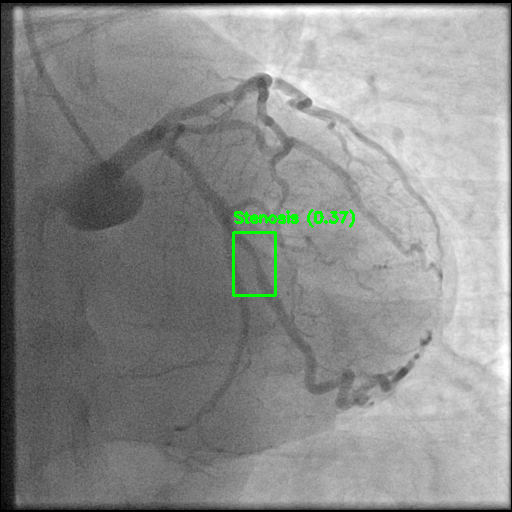

In [ ]:
visualize_detections(image_path, detections)

In [ ]:
import os

def run_combined_model_on_dataset(test_folder, gt_boxes):
    """
    Runs YOLO+MobileNet on all test images and collects final detections.

    test_folder: Path to test images
    gt_boxes: Ground truth labels {filename: [[xmin, ymin, xmax, ymax, class]]}

    Returns: Dictionary {filename: [final detections]}
    """
    combined_detections = {}

    for filename in os.listdir(test_folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(test_folder, filename)
            detections = detect_stenosis(image_path)  # Run YOLO + MobileNet

            combined_detections[filename] = detections

    return combined_detections


In [ ]:
# Run the model on all test images
test_folder = "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/"
final_detections = run_combined_model_on_dataset(test_folder, gt_boxes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/10.png: 512x512 1 stenosis, 448.6ms
Speed: 2.1ms preprocess, 448.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/126.png: 512x512 1 stenosis, 316.9ms
Speed: 1.6ms preprocess, 316.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/139.png: 512x512 (no detections), 320.3ms
Speed: 1.5ms preprocess, 320.3ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/135.png: 512x512 (no detections), 315.4ms
Speed: 1.3ms preprocess, 315.4ms inference, 0.5ms postprocess per imag

In [ ]:
import numpy as np

def compute_iou(pred_box, gt_box):
    """
    Compute IoU (Intersection over Union) between a predicted bbox and ground truth bbox.
    """
    xA = max(pred_box[0], gt_box[0])  # Intersection xmin
    yA = max(pred_box[1], gt_box[1])  # Intersection ymin
    xB = min(pred_box[2], gt_box[2])  # Intersection xmax
    yB = min(pred_box[3], gt_box[3])  # Intersection ymax

    # Compute intersection area
    inter_area = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of both boxes
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

    # Compute IoU
    iou = inter_area / float(pred_box_area + gt_box_area - inter_area + 1e-6)
    return iou

def compute_metrics(yolo_mobilenet_detections, gt_boxes, iou_threshold=0.5):
    """
    Computes precision, recall, and F1-score for YOLO+MobileNet detections.

    - yolo_mobilenet_detections: {filename: [[xmin, ymin, xmax, ymax, confidence]]}
    - gt_boxes: {filename: [[xmin, ymin, xmax, ymax, class]]}
    - iou_threshold: IoU threshold to count a TP.

    Returns: Precision, Recall, F1-score
    """
    true_positives, false_positives, false_negatives = 0, 0, 0

    for filename, gt_list in gt_boxes.items():
        pred_list = yolo_mobilenet_detections.get(filename, [])  # Get detections for this file
        matched = set()  # Track matched GT boxes

        for pred_box in pred_list:
            best_iou, best_gt_idx = 0, -1

            for idx, gt_box in enumerate(gt_list):
                iou = compute_iou(pred_box[:4], gt_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            # If IoU exceeds threshold, it's a TP
            if best_iou >= iou_threshold and best_gt_idx not in matched:
                true_positives += 1
                matched.add(best_gt_idx)
            else:
                false_positives += 1  # YOLO predicted a wrong box

        # Unmatched GT boxes are FN
        false_negatives += len(gt_list) - len(matched)

    # Compute Precision, Recall, and F1-score
    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, f1_score


In [ ]:
precision, recall, f1 = compute_metrics(final_detections, gt)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Precision: 0.3862, Recall: 0.3472, F1-score: 0.3656


UNet Segmentation

In [ ]:
def detect_stenosis(image_path):
    """
    Runs UNet segmentation, applies the mask to the original image,
    then runs YOLOv9 on the masked image, and finally refines detections using MobileNetV3.
    """
    # Step 1: Segment the Artery (UNet)
    mask = segment_artery(image_path)

    # Step 2: Apply Mask to Angiogram
    masked_image = apply_mask(image_path, mask)

    # Save Masked Image (For Debugging)
    cv2.imwrite("masked_image.png", masked_image)

    # Step 3: Run YOLOv9 on Masked Image
    results = yolo_model(masked_image)

    final_detections = []

    for result in results:
        for box in result.boxes.data:
            xmin, ymin, xmax, ymax, confidence, class_id = box.cpu().numpy()

            # Step 4: Run MobileNetV3 on Full Image
            image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(image_rgb, (512, 512)) / 255.0  # Normalize
            image_input = np.expand_dims(image_resized, axis=0)
            mobilenet_pred = mobilenet_model.predict(image_input)

            # If MobileNet Confirms Stenosis, Keep the Detection
            if np.argmax(mobilenet_pred) == 0:  # Class 0 = Stenosis
                final_detections.append([xmin, ymin, xmax, ymax, confidence])

    return final_detections  # YOLO Detections Confirmed by MobileNet


In [ ]:
import json
import numpy as np
import cv2
import os

# Paths
json_path = "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/annotations/test.json"  # Update path
image_folder = "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/"  # Update path
mask_output_folder = "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test_masks/"

# Create output folder for masks
os.makedirs(mask_output_folder, exist_ok=True)

# Load annotations
with open(json_path, "r") as f:
    coco_data = json.load(f)

# Process each annotation
for ann in coco_data["annotations"]:
    image_id = ann["image_id"]
    segmentation = ann["segmentation"]  # Segmentation points
    bbox = ann["bbox"]  # Bounding box (not needed for masks)

    # Load corresponding image to get size
    image_filename = f"{image_id}.png"  # Update based on your filenames
    image_path = os.path.join(image_folder, image_filename)

    if not os.path.exists(image_path):
        print(f"⚠️ Warning: Image {image_filename} not found, skipping.")
        continue

    img = cv2.imread(image_path)
    h, w, _ = img.shape

    # Create an empty mask
    mask = np.zeros((h, w), dtype=np.uint8)

    # Draw segmentation as filled polygon
    for seg in segmentation:
        points = np.array(seg, dtype=np.int32).reshape(-1, 2)  # Convert list to (x,y) pairs
        cv2.fillPoly(mask, [points], color=255)  # White mask (255) for stenosis

    # Save mask
    mask_filename = f"{image_id}.png"  # Mask will be saved as PNG
    cv2.imwrite(os.path.join(mask_output_folder, mask_filename), mask)

print("Mask generation complete!")


✅ Mask generation complete!


In [ ]:
import cv2
import numpy as np
from skimage.morphology import skeletonize

def extract_centerline(binary_mask):
    """
    Extracts the centerline of the artery from a binary segmentation mask using skeletonization.
    """
    # Convert to binary if not already
    binary_mask = (binary_mask > 0).astype(np.uint8)

    # Apply skeletonization
    skeleton = skeletonize(binary_mask)

    return skeleton.astype(np.uint8) * 255  # Convert to 0-255 scale for visualization


In [ ]:
def extract_contour(binary_mask):
    """
    Extracts the outer contour of the segmented artery.
    """
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the largest contour (assuming it represents the artery)
    contours = max(contours, key=cv2.contourArea)

    return contours


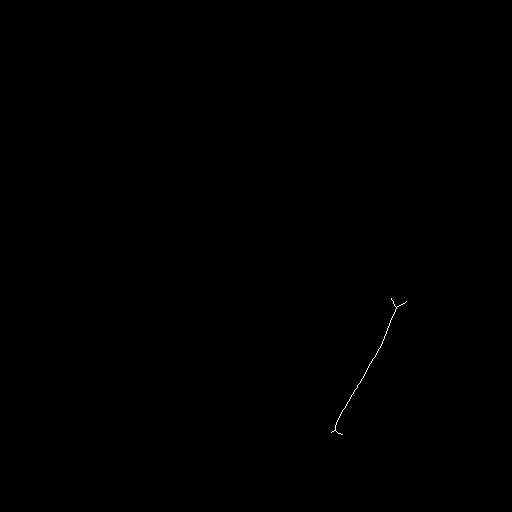

In [ ]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from google.colab.patches import cv2_imshow

# Load the binary mask
binary_mask = cv2.imread("/content/drive/MyDrive/Stenosis detection/arcade/stenosis/masks/1.png", cv2.IMREAD_GRAYSCALE)

# Ensure it's binary (0s and 255s)
binary_mask = (binary_mask > 127).astype(np.uint8)  # Convert grayscale to binary (0,1)

# Extract centerline
centerline = extract_centerline(binary_mask)

# Save or display result
cv2.imwrite("centerline.png", centerline)
cv2_imshow( centerline)
cv2.waitKey(0)
cv2.destroyAllWindows()


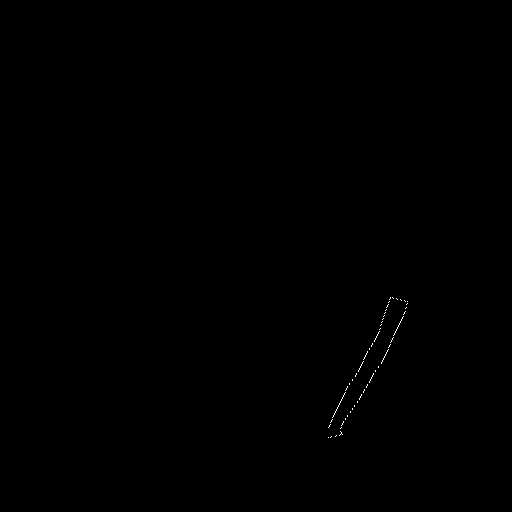

In [ ]:
contours = extract_contour(binary_mask)

# Draw contours on an empty canvas
contour_image = np.zeros_like(binary_mask)
cv2.drawContours(contour_image, contours, -1, (255), 1)  # Draw in white (255)

# Save or display result
cv2.imwrite("contour_image.png", contour_image)
cv2_imshow(contour_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

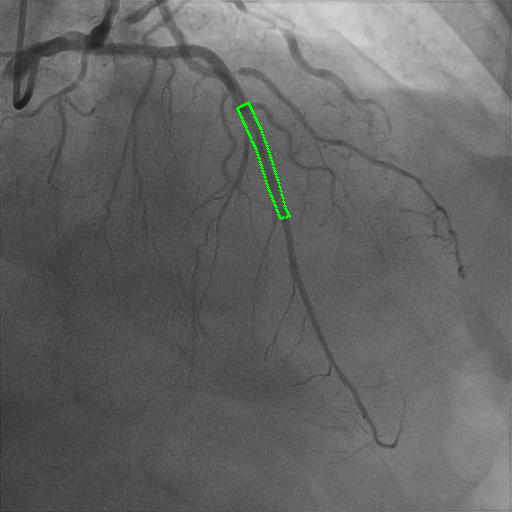

In [ ]:
angiogram = cv2.imread("/content/drive/MyDrive/Stenosis detection/arcade/stenosis/train/images/2.png")
centerline_colored = cv2.cvtColor(centerline, cv2.COLOR_GRAY2BGR)
binary_mask = cv2.imread("/content/drive/MyDrive/Stenosis detection/arcade/stenosis/masks/2.png", cv2.IMREAD_GRAYSCALE)

# Extract contours & centerline
contours = extract_contour(binary_mask)
centerline = extract_centerline(binary_mask)

# Draw contours on the angiogram
cv2.drawContours(angiogram, contours, -1, (0, 255, 0), 2)  # Green for contours

# Overlay centerline (in blue)
#angiogram[centerline > 0] = [255, 0, 0]  # Blue for centerline

# Display the result
cv2_imshow(angiogram)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def compute_diameter_profile(centerline, binary_mask, cf=0.1408):
    diameters = []
    for point in np.argwhere(centerline > 0):  # Iterate over centerline pixels
        x, y = point

        # Find distances to vessel contour
        distances = []
        for contour in extract_contour(binary_mask):
            cx, cy = contour[0]
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            distances.append(dist)

        if distances:
            diameter_pixels = 2 * min(distances)  # Diameter in pixels
            diameter_mm = diameter_pixels * cf   # Convert to mm
            diameters.append(diameter_mm)
        else:
            diameters.append(0)  # Fallback if no valid measurement

    return np.array(diameters)


In [ ]:
def compute_diameter_profile(centerline, binary_mask):
    diameters = []
    for point in np.argwhere(centerline > 0):  # Iterate over centerline pixels
        x, y = point

        # Find distances to vessel contour
        distances = []
        for contour in extract_contour(binary_mask):
            cx, cy = contour[0]
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            distances.append(dist)

        if distances:  # Ensure valid distances exist
            diameters.append(2 * min(distances))  # Approximate diameter
        else:
            diameters.append(0)  # Fallback if no valid measurement

    return np.array(diameters)


In [ ]:
def compute_mld(diameters):
    """
    Finds the minimum lumen diameter (MLD).
    """
    return np.min(diameters)


In [ ]:
def compute_ref_diameter(diameters):
    """
    Estimates the reference diameter (healthy artery segment).
    """
    return np.max(diameters)  # Assuming widest section is the normal vessel


In [ ]:
def compute_percent_mld(mld, ref_d):
    """
    Computes the percentage stenosis based on MLD and Reference Diameter.
    """
    return (1 - (mld / ref_d)) * 100


In [ ]:
def compute_lumen_area(binary_mask):
    """
    Computes the minimum lumen area.
    """
    return np.sum(binary_mask)  # Count pixels in lumen (assuming 1 pixel = known mm²)


In [ ]:
def compute_stenotic_length(centerline, diameters, mld):
    """
    Computes the length of the stenotic region.
    """
    stenotic_region = diameters < (mld * 1.1)  # Threshold for narrowing
    return np.sum(stenotic_region)  # Length in pixels


In [ ]:
import matplotlib.pyplot as plt

def plot_diameter_profile(diameters):
    plt.figure(figsize=(8, 4))
    plt.plot(diameters, label="Diameter (mm)", color='blue')
    plt.axhline(y=compute_mld(diameters), color='r', linestyle='--', label="MLD")
    plt.xlabel("Distance along artery")
    plt.ylabel("Diameter (mm)")
    plt.legend()
    plt.show()


In [ ]:
def generate_qca_report(diameters, binary_mask):
    mld = compute_mld(diameters)
    ref_d = compute_ref_diameter(diameters)
    percent_mld = compute_percent_mld(mld, ref_d)
    mla = compute_lumen_area(binary_mask)
    stenotic_length = compute_stenotic_length(diameters, mld)

    return {
        "MLD": mld,
        "Reference Diameter": ref_d,
        "%MLD": percent_mld,
        "MLA": mla,
        "Stenotic Length": stenotic_length
    }


In [ ]:
centerline = extract_centerline(binary_mask)
print(type(centerline))  # Check if it's a numpy array or something else
print(centerline)  # See what the function actually returns


<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
def get_centerline_points(centerline):
    """
    Extracts the coordinates of centerline pixels.
    """
    points = np.column_stack(np.where(centerline > 0))  # Get (y, x) coordinates
    return points[:, ::-1]  # Convert to (x, y) format

centerline_points = get_centerline_points(centerline)


In [ ]:
diameter_profile = compute_diameter_profile(centerline_points, binary_mask)



In [ ]:
compute_ref_diameter(diameter_profile)

73.34206992224858

In [ ]:
compute_mld(diameter_profile)

44.64758897499394

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input

def unet_model(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = UpSampling2D((2, 2))(p2)
    d1 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(d1)
    d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d2)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet_model()
# Save the full model

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 295,937 (1.13 MB)

 Trainable params: 295,937 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and normalization for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

# Load training images and masks
train_image_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Stenosis detection/arcade/train_images/",
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42
)

train_mask_generator = mask_datagen.flow_from_directory(
  "/content/drive/MyDrive/Stenosis detection/arcade/train_masks/",
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42
)

# Load validation images and masks
val_image_generator = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/Stenosis detection/arcade/val_images/",
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42
)

val_mask_generator = val_mask_datagen.flow_from_directory(
    "/content/drive/MyDrive/Stenosis detection/arcade/val_masks/",
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42
)

# Function to create a generator that yields (image, mask) pairs
def image_segmentation_generator(image_generator, mask_generator):
    while True:
        X = next(image_generator)
        Y = next(mask_generator)
        yield X, Y

# Create generators for training and validation
train_generator = image_segmentation_generator(train_image_generator, train_mask_generator)
val_generator = image_segmentation_generator(val_image_generator, val_mask_generator)



Found 997 images belonging to 1 classes.
Found 997 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_unet(model, train_generator, val_generator, epochs=50, batch_size=8, save_path="unet_model.h5"):
    """
    Trains the UNet model and saves the best weights.

    Parameters:
    - model: Compiled UNet model.
    - train_generator: Generator for training data.
    - val_generator: Generator for validation data.
    - epochs: Number of epochs to train.
    - batch_size: Batch size for training.
    - save_path: Path to save the trained model.
    """

    # Callbacks for early stopping and best model saving
    checkpoint = ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, mode="min", verbose=1)
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_image_generator),  # Number of batches per epoch
        validation_data=val_generator,
        validation_steps=len(val_image_generator),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    # Save the final model
    model.save(save_path)
    print(f"✅ Model saved at {save_path}")

    return history  # Return training history




In [ ]:
# Assuming `unet_model` is already defined
history = train_unet(model=model, train_generator=train_generator, val_generator=val_generator, epochs=50, save_path="unet_best_model.keras")


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9946 - loss: 0.0336
Epoch 1: val_loss improved from inf to 0.03350, saving model to unet_best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9946 - loss: 0.0336 - val_accuracy: 0.9952 - val_loss: 0.0335
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9947 - loss: 0.0296
Epoch 2: val_loss improved from 0.03350 to 0.03189, saving model to unet_best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.9947 - loss: 0.0296 - val_accuracy: 0.9953 - val_loss: 0.0319
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9948 - loss: 0.0256
Epoch 3: val_loss did not improve from 0.03189
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.9948 - loss: 0.0256 - val_accuracy: 0.9953 - val_loss: 0.0336
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9949 - loss: 0.0241
Epoch 4: val_loss did not improve from 0.03189
125/125 ━━━━━━━━━━